# Source code for "Designing materials by laser powder bed fusion with machine learning-driven multi-objective optimization"

This source code addresses a multi-objective optimization problem focusing on the Density and Amorphicity of metal components produced through Laser Powder Bed Fusion (LPBF). The training dataset consists of 180 points obtained by varying the Power, Hatching distance and Scanning velocity prinitng parameters.
Details of the dataset are provided in the paper [Kosiba, Kononenko, Chernyavsky, Journal of Alloys and Compounds, 168946, 2023](https://doi.org/10.1016/j.jallcom.2023.168946). Data is available from the corresponding authors on reasonable request.
Gaussian Process Regression (GPR) models are employed for analysis. To model Amorphicity accurately, a Heteroscedastic GPR is utilized, as it aligns well with our dataset characteristics. These trained models are subsequently applied in a bi-objective optimization process using the NSGA-II method.


In [2]:
# data processing
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# models
# from sklearn.gaussian_process import GaussianProcessRegressor
from gpr_custom import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from hgpr import HGPR

# data adapter
from data_adapter import DatasetPrint3D

# utilities
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold, GridSearchCV, LeaveOneOut, cross_val_score

# multi-obj optimization
from pymoo.optimize import minimize 
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.indicators.hv import Hypervolume
from pymoo.config import Config
Config.warnings['not_compiled'] = False


# 1. Dataset

In [3]:
data_file = 'dat/LPBF_Vit105_dataset_ML.xlsx' 
dataset = DatasetPrint3D(data_file, label='train')
df = dataset.data_pd_aver

In [4]:
df.head()

,abbr.,Power [W],hatching distance [µm],scanning velocity [m/s],ΔHx [J/g],ΔHx [%],density [g/cm3],density [%],ΔHx [J/g]_std,ΔHx [%]_std,density [g/cm3]_std,density [%]_std,Energy density [MJ / m^2],Enthalpy,Mod Enthalpy 1,Mod Enthalpy 2,label
0,A14a,90,180,0.7,-67.975933,93.473814,6.661433,99.657905,1.654237,2.274743,0.008087,0.120987,0.714286,107.570575,0.597614,8.017837,train
1,A16a,90,180,0.8,-70.216100,96.554270,6.632100,99.219066,0.348254,0.478885,0.033657,0.503526,0.625000,100.623059,0.559017,7.500000,train
2,A18a,90,180,0.9,-70.571833,97.043440,6.636867,99.290377,0.396506,0.545236,0.038890,0.581812,0.555556,94.868330,0.527046,7.071068,train
3,A20a,90,180,1.0,-70.625433,97.117145,6.628300,99.162216,0.815907,1.121955,0.001499,0.022424,0.500000,90.000000,0.500000,6.708204,train
4,A22a,90,180,1.1,-70.457067,96.885624,6.594067,98.650071,1.259986,1.732609,0.015868,0.237393,0.454545,85.811633,0.476731,6.396021,train


In [5]:
fig = px.scatter_3d(
    df, 
    x='Power [W]', 
    y='hatching distance [µm]', 
    z='scanning velocity [m/s]', 
    color='density [%]',
    )
fig.update_layout(
    width=700,
)
fig.show()

In [6]:
fig = px.scatter_3d(
    df, 
    x='Power [W]', 
    y='hatching distance [µm]', 
    z='scanning velocity [m/s]', 
    color='ΔHx [%]',
    )
fig.update_layout(
    width=700,
)
fig.show()

In [7]:
# experimental predictors, measured target_features 
X_init, D_init = dataset.X_Density_init       # all experimental points
X_init_a, A_init = dataset.X_Amorphisity_init

# experimental predictors, mean of the target_feature, standart deviation fo the target feature
X, D, D_std = dataset.X_Density # averaged experimental points
Xa, A, A_std = dataset.X_Amorphicity

# experimental params grid
# min max
minP, maxP = np.min(X[:, 0]), np.max(X[:, 0])
minH, maxH = np.min(X[:, 1]), np.max(X[:, 1])
minV, maxV = np.min(X[:, 2]), np.max(X[:, 2])
# steps
dP = sorted(set(X[:, 0]))[1] - sorted(set(X[:, 0]))[0]
dH = sorted(set(X[:, 1]))[1] - sorted(set(X[:, 1]))[0]
dV = sorted(set(X[:, 2]))[1] - sorted(set(X[:, 2]))[0]

print(f'Params grid shape: {X.shape}')
print(f'Density min: {np.min(D):.2f}, max: {np.max(D):.2f}, mean: {D.mean():.2f}')
print(f'Amrphisity min: {np.min(A):.2f}, max: {np.max(A):.2f}, mean: {A.mean():.2f}')
print(f'Power min: {minP:.2f}, max: {maxP:.2f}, step: {dP:.2f}')
print(f'Hatching dist. min: {minH:.2f}, max: {maxH:.2f}, step: {dH:.2f}')
print(f'Printing velocity min: {minV:.2f}, max: {maxV:.2f}, step: {dV:.2f}')
print(f'Max dens: {np.max(D):.2f} min dens: {np.min(D):.2f}')

Params grid shape: (60, 3)
Density min: 95.89, max: 100.17, mean: 99.06
Amrphisity min: 73.28, max: 98.85, mean: 95.89
Power min: 90.00, max: 120.00, step: 10.00
Hatching dist. min: 180.00, max: 220.00, step: 20.00
Printing velocity min: 0.70, max: 1.10, step: 0.10
Max dens: 100.17 min dens: 95.89


# 2. Models

In [8]:
kernel = ConstantKernel(1.0, (1e-3, 1e3)) *\
         Matern(
            length_scale=[3, 3, 3], 
            length_scale_bounds=((1e-2, 1e5), (1e-2, 1e5), (1e-2, 1e5)),  
            nu=3/2
        )
# GPR model for predicition of the density 
model_dens = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('gpr', GaussianProcessRegressor(kernel=kernel, alpha_fit=True, n_restarts_optimizer=25))
])

# HGPR model for prediciton of the amorphicity 
model_amor = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('gpr', HGPR(
        GaussianProcessRegressor(kernel=kernel, alpha_fit=True, n_restarts_optimizer=25), 
        GaussianProcessRegressor(kernel=kernel, alpha_fit=True, n_restarts_optimizer=25), 
        num_iters=10
        )
    )
])

In [9]:
# train GPR model for density and HGPR model for amorphicity
model_dens.fit(X_init, D_init.astype(float))
model_amor.fit(X_init, A_init.astype(float))

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('gpr', <hgpr.HGPR object at 0x1614ea320>)])

In [10]:
D_pred, D_pred_std = model_dens.predict(X, return_std=True)
A_pred, A_pred_std = model_amor.predict(X, return_std=True)

print(f'RMSE density: {mean_squared_error(D_pred, D, squared=False):.6f} %')
print(f'RMSE amorphicity: {mean_squared_error(A_pred, A, squared=False):.6f} %')

RMSE density: 0.110728 %
RMSE amorphicity: 0.930862 %


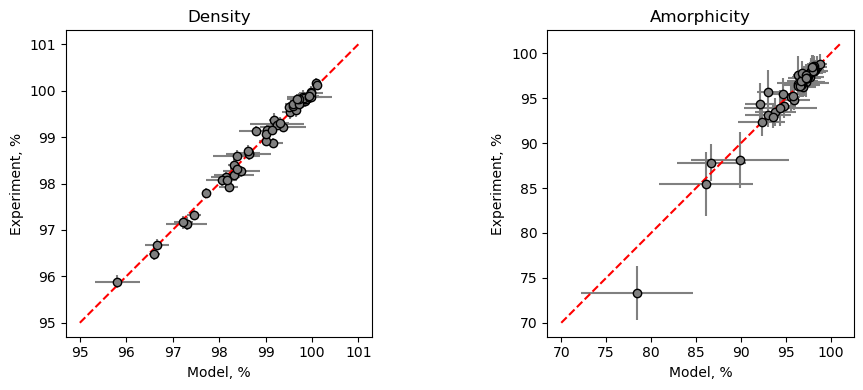

In [11]:
# Creating a figure with two subplots in one row
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plotting on the first subplot
axes[0].errorbar(D_pred, D, D_pred_std, D_std, 'o', color='gray', markeredgecolor='black')
axes[0].plot([95, 101], [95, 101], '--', color='red')
axes[0].set_title('Density')
axes[0].set_xlabel('Model, %')
axes[0].set_ylabel('Experiment, %')
axes[0].set_aspect('equal')

# Plotting on the second subplot
axes[1].errorbar(A_pred, A, A_pred_std, A_std, 'o', color='gray', markeredgecolor='black')
axes[1].plot([70, 101], [70, 101], '--', color='red')
axes[1].set_title('Amorphicity')
axes[1].set_xlabel('Model, %')
axes[1].set_ylabel('Experiment, %')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# 3. Bi-objective Optimization

In [12]:
def amor_dens(point):
    """Function-wrapper for predictive models
    Args:
        point: (list) [power, hatch distance, scanning velocity] at which evaluate the models
    Returns:
        (list) [density, amorphicity]
    """
    # point_scaled = scaler_Xinit.transform([point])
    dens = - model_dens.predict([point])[0]
    amor = - model_amor.predict([point])[0]
    return (dens, amor)

class ProblemWrapper(Problem):

    def _evaluate(self, points, out, *args, **kwargs):
        res = []

        for point in points:
            res.append(amor_dens(point))
        
        out['F'] = np.array(res)

In [13]:
problem = ProblemWrapper(n_var=3, n_obj=2, xl=[minP, minH, minV], xu=[maxP, maxH, maxV])

algorithm = NSGA2(pop_size=1000)
termination = ('n_gen', 300)

In [14]:
results = minimize(
    problem=problem,
    algorithm=algorithm,
    termination=termination,
    save_history=True,
    verbose=False
)


In [17]:
res_df = pd.DataFrame(np.concatenate((results.X, (-1) * results.F), axis=1), columns=['Power', 'Hatch distance', 'Scanning velocity', 'Density', 'Amorphicity'])

print('Optimal Solutions:')
print(res_df[:3])

Optimal Solutions:
        Power  Hatch distance  Scanning velocity     Density  Amorphicity
0   95.791100      190.868638           0.804524   99.151838    99.325284
1  115.118241      190.433106           0.916580  100.176124    95.948838
2  115.115366      190.433106           0.917429  100.176119    95.966204


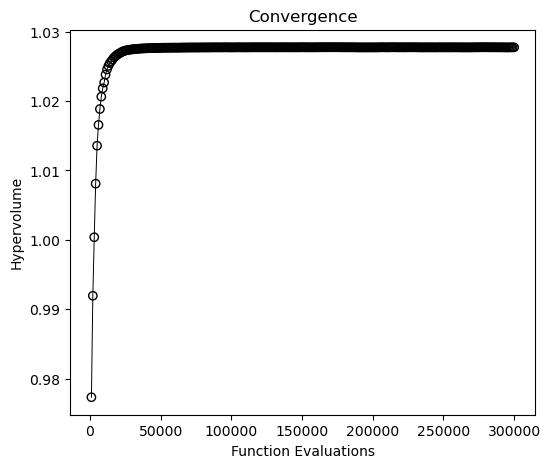

In [16]:
# check the convergence of hypervolume
num_evaluations = []
objective_space_values = []
for generation_info in results.history:
    # Extracting information from the current generation
    num_evaluations.append(generation_info.evaluator.n_eval)  # Store the number of function evaluations
    optimizer_info = generation_info.opt  # Retrieve the optimum from the algorithm
    # Filtering out only the feasible solutions and appending the objective space values
    feasible_indices = np.where(optimizer_info.get("feasible"))[0]
    objective_space_values.append(optimizer_info.get("F")[feasible_indices])

approx_ideal = results.F.min(axis=0)
approx_nadir = results.F.max(axis=0)
ref_point = np.array([1.1, 1.1])

metric = Hypervolume(ref_point=ref_point,
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hypervolume = [metric.do(_F) for _F in objective_space_values]

plt.figure(figsize=(6, 5))
plt.plot(num_evaluations, hypervolume,  color='black', lw=0.7)
plt.scatter(num_evaluations, hypervolume,  facecolor="none", edgecolor='black', marker="o")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()